In [200]:
import numpy as np
from scipy.optimize import linprog
from scipy.optimize import minimize
import quadprog

def linear_solver(n, M):
	M -= np.amin(M)	# Let zero sum game at least with nonnegative payoff
	c = np.ones((n))
	b = np.ones((n))
	res = linprog(-c, A_ub = M.T, b_ub = b)
	w = res.x
	return w/np.sum(w)

def quadratic_solver(n, M, bbb , regularizer):
    qp_G = np.matmul(M, M.T)
    qp_G += regularizer * np.eye(n)

    qp_a = np.matmul(M, bbb)###np.zeros(n, dtype = np.float64)

    qp_C = np.zeros((n,n+1), dtype = np.float64)
    for i in range(n):
        qp_C[i,0] = 1.0
        qp_C[i,i+1] = 1.0
    qp_b = np.zeros(n+1, dtype = np.float64)
    qp_b[0] = 1.0
    meq =1
    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    w = res[0]
    return w

"""
def quadratic_solver(n, M, bbb , regularizer):
    qp_G = np.matmul(M, M.T)
    qp_G += regularizer * np.eye(n)

    qp_a = np.matmul(M, bbb)###np.zeros(n, dtype = np.float64)

    qp_C = np.zeros((n,n), dtype = np.float64)
    for i in range(n):
        qp_C[i,0] = 0.0
        qp_C[i,i] = 1.0
    qp_b = np.zeros(n, dtype = np.float64)
    qp_b[0] = 0.0
    meq =0.0
    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    w = res[0]
    return w
"""
'''
def quadratic_solver_extend(n, M, b, regularizer):
	qp_G = np.matmul(M, M.T)
	qp_G += regularizer * np.eye(n)
	
	qp_a = np.matmul(b[None, :], M.T).reshape(-1)

	qp_C = np.zeros((n,n+1), dtype = np.float64)
	for i in range(n):
		qp_C[i,0] = 1.0
		qp_C[i,i+1] = 1.0
	qp_b = np.zeros(n+1, dtype = np.float64)
	qp_b[0] = 1.0
	meq = 1
	res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
	w = res[0]
	return w
'''

class Density_Ratio_discrete(object):
    def __init__(self, num_state):
        self.num_state = num_state
        self.Ghat = np.zeros([num_state, num_state], dtype = np.float64)
        self.Nstate = np.zeros([num_state, 1], dtype = np.float64)

    def reset(self):
        num_state = self.num_state
        self.Ghat = np.zeros([num_state, num_state], dtype = np.float64)
        self.Nstate = np.zeros([num_state, 1], dtype = np.float64)

    def feed_data(self, cur, next, policy_ratio):
        self.Ghat[cur, next] += policy_ratio
        self.Ghat[next, next] -= 1.0
        self.Nstate[cur] += 0.5
        self.Nstate[next] += 0.5

    def density_ratio_estimate_old(self):
        Frequency = (self.Nstate + 1e-5)
        Frequency = Frequency / np.sum(Frequency)
        G = self.Ghat / Frequency
        n = self.num_state
        x = quadratic_solver(n, G/100.0)
        #x2 = linear_solver(n, G)
        #print x
        #print x2
        #print np.sum((x-x2)*(x-x2))
        w = x/Frequency.reshape(-1)
        return x, w

    def density_ratio_estimate(self, regularizer = 0.001):
        Frequency = self.Nstate.flat
        tvalid = np.where(Frequency >= 1e-9)	
        G = np.zeros_like(self.Ghat)
        Frequency = Frequency/np.sum(Frequency)
        G[tvalid] = self.Ghat[tvalid]/(Frequency[:,None])[tvalid]		
        n = self.num_state
        x = quadratic_solver(n, G/50.0, regularizer)
        w = np.zeros(self.num_state)
        w[tvalid] = x[tvalid]/Frequency[tvalid]
        return x, w

    def density_ratio_estimate_exact(self):
        Frequency = self.Nstate.flat
        tvalid = np.where(Frequency >= 1e-9)	
        G = np.zeros_like(self.Ghat)
        Frequency = Frequency/np.sum(Frequency)
        G = self.Ghat[tvalid, tvalid]/(Frequency[:,None])[tvalid]
        G = G/np.linalg.norm(G, 'fro')
        n = Frequency[tvalid].shape[0]
        x = np.zeros(self.num_state)
        x[tvalid] = quadratic_solver(n, G)
        w = np.zeros(self.num_state)
        w[tvalid] = x[tvalid]/Frequency[tvalid]
        return x, w

class Density_Ratio_discounted(object):
    def __init__(self, num_state, gamma):
        self.num_state = num_state
        self.Ghat = np.zeros([num_state, num_state], dtype = np.float64)
        self.Nstate = np.zeros([num_state, 1], dtype = np.float64)
        self.auxi = np.zeros([num_state, 1], dtype = np.float64)
        self.gamma = gamma
        #####self.initial_b = np.zeros([num_state], dtype = np.float64)self.gamma = gamma

    def reset(self):
        num_state = self.num_state
        self.Ghat = np.zeros([num_state, num_state], dtype = np.float64)
        self.Nstate = np.zeros([num_state, 1], dtype = np.float64)

    def feed_data(self, cur, next, initial, policy_ratio, discounted_t):
        if cur == -1:
            self.Ghat[next, next] -= 1.0
        else:
            self.Ghat[cur, next] += self.gamma*policy_ratio 
            ###self.Ghat[cur, initial] += (1-self.gamma)/self.gamma * discounted_t
            self.Ghat[next, next] -= 1.0 
            self.auxi += (1.0-self.gamma)*1.0/self.num_state*np.ones([self.num_state, 1], dtype = np.float64)
            ####self.Ghat[next, next] -= discounted_t
            self.Nstate[cur] += 1.0 #####discounted_t

    def density_ratio_estimate(self, regularizer = 0.001):
        Frequency = self.Nstate.reshape(-1)
        auxi = self.auxi.reshape(-1)
        print self.auxi.shape
        tvalid = np.where(Frequency >= 1e-3)
        G = np.zeros_like(self.Ghat)
        auxi = auxi*0.0
        Frequency = Frequency/np.sum(Frequency)
        auxi[tvalid] = self.auxi[tvalid].reshape(-1)####/Frequency[tvalid]
        G[tvalid] = self.Ghat[tvalid]####/(Frequency[:,None])[tvalid]		

        n = self.num_state
        np.save("GGG.npy",G)
        np.save("aixo.npy",auxi)
        np.save("frequency.npy",Frequency)
        x = quadratic_solver(n, G/10000.0,auxi/10000.0, 1.0*regularizer)
        w = np.zeros(self.num_state)
        w[tvalid] = x[tvalid]#####/Frequency[tvalid]        
        ###w[w>3.0] = 0.0
        return x, w



In [201]:
import os
import sys
import argparse
import optparse
import subprocess
import numpy as np
#######from Density_Ratio_discrete import Density_Ratio_discrete, Density_Ratio_discounted
from Q_learning import Q_learning
from environment import random_walk_2d, taxi
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# import seaborn as sns
# sns.set(style="white")


def roll_out(state_num, env, policy, num_trajectory, truncate_size):
    SASR = []
    total_reward = 0.0
    frequency = np.zeros(state_num)
    for i_trajectory in range(num_trajectory):
        state = env.reset()
        sasr = []
        for i_t in range(truncate_size):
            #env.render()
            p_action = policy[state, :]
            action = np.random.choice(p_action.shape[0], 1, p = p_action)[0]
            next_state, reward = env.step(action)

            sasr.append((state, action, next_state, reward))
            frequency[state] += 1
            total_reward += reward
            #print env.state_decoding(state)
            #a = input()

            state = next_state
        SASR.append(sasr)
    return SASR, frequency, total_reward/(num_trajectory * truncate_size)

def train_density_ratio(SASR, policy0, policy1, den_discrete, gamma):
    for sasr in SASR:
        discounted_t = 1.0
        initial_state = sasr[0,0]
        for state, action, next_state, reward in sasr:
            discounted_t = gamma
            policy_ratio = policy1[state, action]/policy0[state, action]
            den_discrete.feed_data(state, next_state, initial_state, policy_ratio, discounted_t)
        ####den_discrete.feed_data(-1, initial_state, initial_state, 1, discounted_t)

    x, w = den_discrete.density_ratio_estimate()
    return x, w

def off_policy_evaluation_density_ratio(SASR, policy0, policy1, density_ratio, gamma):
    total_reward = 0.0
    self_normalizer = 0.0
    for sasr in SASR:
        discounted_t = gamma
        for state, action, next_state, reward in sasr:
            policy_ratio = policy1[state, action]/policy0[state, action]
            total_reward += density_ratio[state] * policy_ratio * reward #### * discounted_t
            self_normalizer += density_ratio[state] * policy_ratio ######* discounted_t
            #######discounted_t = gamma
    return total_reward / self_normalizer

def on_policy(SASR, gamma):
    total_reward = 0.0
    self_normalizer = 0.0
    for sasr in SASR:
        discounted_t = 1.0
        for state, action, next_state, reward in sasr:
            total_reward += reward * discounted_t
            self_normalizer += discounted_t
            discounted_t *= gamma
    return total_reward / self_normalizer

def importance_sampling_estimator(SASR, policy0, policy1, gamma):
    mean_est_reward = 0.0
    for sasr in SASR:
        log_trajectory_ratio = 0.0
        total_reward = 0.0
        discounted_t = 1.0
        self_normalizer = 0.0
        for state, action, next_state, reward in sasr:
            log_trajectory_ratio += np.log(policy1[state, action]) - np.log(policy0[state, action])
            total_reward += reward * discounted_t
            self_normalizer += discounted_t
            discounted_t *= gamma
        avr_reward = total_reward / self_normalizer
        mean_est_reward += avr_reward * np.exp(log_trajectory_ratio)
    mean_est_reward /= len(SASR)
    return mean_est_reward

def importance_sampling_estimator_stepwise(SASR, policy0, policy1, gamma):
    mean_est_reward = 0.0
    for sasr in SASR:
        step_log_pr = 0.0
        est_reward = 0.0
        discounted_t = 1.0
        self_normalizer = 0.0
        for state, action, next_state, reward in sasr:
            step_log_pr += np.log(policy1[state, action]) - np.log(policy0[state, action])
            est_reward += np.exp(step_log_pr)*reward*discounted_t
            self_normalizer += discounted_t
            discounted_t *= gamma
        est_reward /= self_normalizer
        mean_est_reward += est_reward
    mean_est_reward /= len(SASR)
    return mean_est_reward

def weighted_importance_sampling_estimator(SASR, policy0, policy1, gamma):
    total_rho = 0.0
    est_reward = 0.0
    for sasr in SASR:
        total_reward = 0.0
        log_trajectory_ratio = 0.0
        discounted_t = 1.0
        self_normalizer = 0.0
        for state, action, next_state, reward in sasr:
            log_trajectory_ratio += np.log(policy1[state, action]) - np.log(policy0[state, action])
            total_reward += reward * discounted_t
            self_normalizer += discounted_t
            discounted_t *= gamma
        avr_reward = total_reward / self_normalizer
        trajectory_ratio = np.exp(log_trajectory_ratio)
        total_rho += trajectory_ratio
        est_reward += trajectory_ratio * avr_reward

    avr_rho = total_rho / len(SASR)
    return est_reward / avr_rho/ len(SASR)

def weighted_importance_sampling_estimator_stepwise(SASR, policy0, policy1, gamma):
    Log_policy_ratio = []
    REW = []
    for sasr in SASR:
        log_policy_ratio = []
        rew = []
        discounted_t = 1.0
        self_normalizer = 0.0
        for state, action, next_state, reward in sasr:
            log_pr = np.log(policy1[state, action]) - np.log(policy0[state, action])
            if log_policy_ratio:
                log_policy_ratio.append(log_pr + log_policy_ratio[-1])
            else:
                log_policy_ratio.append(log_pr)
            rew.append(reward * discounted_t)
            self_normalizer += discounted_t
            discounted_t *= gamma
        Log_policy_ratio.append(log_policy_ratio)
        REW.append(rew)
    est_reward = 0.0
    rho = np.exp(Log_policy_ratio)
    #print 'rho shape = {}'.format(rho.shape)
    REW = np.array(REW)
    for i in range(REW.shape[0]):
        est_reward += np.sum(rho[i]/np.mean(rho, axis = 0) * REW[i])/self_normalizer
    return est_reward/REW.shape[0]


def Q_learning(env, num_trajectory, truncate_size, temperature = 2.0):
    agent = Q_learning(n_state, n_action, 0.01, 0.99)

    state = env.reset()
    for k in range(20):
        print 'Training for episode {}'.format(k)
        for i in range(50):
            for j in range(5000):
                action = agent.choose_action(state, temperature)
                next_state, reward = env.step(action)
                agent.update(state, action, next_state, reward)
                state = next_state
        pi = agent.get_pi(temperature)
        np.save('taxi-policy/pi{}.npy'.format(k), pi)
        SAS, f, avr_reward = roll_out(n_state, env, pi, num_trajectory, truncate_size)
        print 'Episode {} reward = {}'.format(k, avr_reward)
        heat_map(length, f, env, 'heatmap/pi{}.pdf'.format(k))

def heat_map(length, f, env, filename):
    p_matrix = np.zeros([length, length], dtype = np.float32)
    for state in range(env.n_state):
        x,y,_,_ = env.state_decoding(state)
        #x,y = env.state_decoding(state)
        p_matrix[x,y] = f[state]
    p_matrix = p_matrix / np.sum(p_matrix)

    sns.heatmap(p_matrix, cmap="YlGnBu")#, vmin = 0.0, vmax = 0.07)
    ppPDF = PdfPages(filename)
    ppPDF.savefig()
    ppPDF.close()
    plt.clf()

def model_based(n_state, n_action, SASR, pi, gamma):
    T = np.zeros([n_state, n_action, n_state], dtype = np.float32)
    R = np.zeros([n_state, n_action], dtype = np.float32)
    R_count = np.zeros([n_state, n_action], dtype = np.int32)
    for sasr in SASR:
        for state, action, next_state, reward in sasr:
            T[state, action, next_state] += 1
            R[state, action] += reward
            R_count[state, action] += 1
    d0 = np.zeros([n_state, 1], dtype = np.float32)

    for state in SASR[:,0,0].flat:
        d0[state, 0] += 1.0
    t = np.where(R_count > 0)
    t0 = np.where(R_count == 0)
    R[t] = R[t]/R_count[t]
    R[t0] = np.mean(R[t])
    T = T + 1e-9	# smoothing
    T = T/np.sum(T, axis = -1)[:,:,None]
    Tpi = np.zeros([n_state, n_state])
    for state in range(n_state):
        for next_state in range(n_state):
            for action in range(n_action):
                Tpi[state, next_state] += T[state, action, next_state] * pi[state, action]
    dt = d0/np.sum(d0)
    dpi = np.zeros([n_state, 1], dtype = np.float32)
    truncate_size = SASR.shape[1]
    discounted_t = 1.0
    self_normalizer = 0.0
    for i in range(truncate_size):
        dpi += dt * discounted_t
        if i < 50:
            dt = np.dot(Tpi.T,dt)
        self_normalizer += discounted_t
        discounted_t *= gamma
    dpi /= self_normalizer
    np.save("Tpi.npy",Tpi)
    np.save("R.npy",R)
    np.save("pi.npy",pi)
    Rpi = np.sum(R * pi, axis = -1)
    np.save("Rpi.npy",Rpi)
    np.save("dpi.npy",dpi)
    return np.sum(dpi.reshape(-1) * Rpi)

def run_experiment(n_state, n_action, SASR, pi0, pi1, gamma):

    den_discrete = Density_Ratio_discounted(n_state, gamma)
    x, w = train_density_ratio(SASR, pi0, pi1, den_discrete, gamma)
    x = x.reshape(-1)
    w = w.reshape(-1)
    np.save("weight.npy",w)
    est_DENR = off_policy_evaluation_density_ratio(SASR, pi0, pi1, w, gamma)
    est_naive_average = on_policy(SASR, gamma)
    est_IST = importance_sampling_estimator(SASR, pi0, pi1, gamma)
    est_ISS = importance_sampling_estimator_stepwise(SASR, pi0, pi1, gamma)
    est_WIST = weighted_importance_sampling_estimator(SASR, pi0, pi1, gamma)
    est_WISS = weighted_importance_sampling_estimator_stepwise(SASR, pi0, pi1, gamma)

    est_model_based = model_based(n_state, n_action, SASR, pi1, gamma)
    #return est_model_based
    return est_DENR, est_naive_average, est_IST, est_ISS, est_WIST, est_WISS, est_model_based







####if __name__ == '__main__':


In [202]:
estimator_name = ['On Policy', 'Density Ratio', 'Naive Average', 'IST', 'ISS', 'WIST', 'WISS', 'Model Based']
length = 5
env = taxi(length)
n_state = env.n_state
n_action = env.n_action

num_trajectory = 200
truncate_size = 400
gamma = 1.0

"""
parser = argparse.ArgumentParser(description='taxi environment')
parser.add_argument('--nt', type = int, required = False, default = num_trajectory)
parser.add_argument('--ts', type = int, required = False, default = truncate_size)
parser.add_argument('--gm', type = float, required = False, default = gamma)
args = parser.parse_args()
"""
behavior_ID = 4
target_ID = 5

pi_target = np.load('taxi-policy/pi19.npy')
alpha = 0.4  # mixture ratio
nt = 200 # num_trajectory
ts = 1000 # truncate_size
gm = 1.0 # gamma
pi_behavior = np.load('taxi-policy/pi18.npy')

pi_behavior = alpha * pi_target + (1-alpha) * pi_behavior

res = np.zeros((8, 20), dtype = np.float32)
for k in range(20):
    print k
    np.random.seed(k)
    SASR0, _, _ = roll_out(n_state, env, pi_behavior, nt, ts)
    res[1:,k] = run_experiment(n_state, n_action, np.array(SASR0), pi_behavior, pi_target, gm)

    np.random.seed(k)
    SASR, _, _ = roll_out(n_state, env, pi_target, nt, ts)
    res[0, k] = on_policy(np.array(SASR), gm)

    print('------seed = {}------'.format(k))
    for i in range(8):
        print('  ESTIMATOR: '+estimator_name[i]+ ', rewards = {}'.format(res[i,k]))
        print('----------------------')
        sys.stdout.flush()
        np.save('result/nt={}ts={}gm={}.npy'.format(nt,ts,gm), res)



0
(2000, 1)
------seed = 0------
  ESTIMATOR: On Policy, rewards = -0.134589999914
----------------------
  ESTIMATOR: Density Ratio, rewards = -0.197024554014
----------------------
  ESTIMATOR: Naive Average, rewards = -0.192444995046
----------------------
  ESTIMATOR: IST, rewards = -0.204850807786
----------------------
  ESTIMATOR: ISS, rewards = -0.107262693346
----------------------
  ESTIMATOR: WIST, rewards = -0.207104235888
----------------------
  ESTIMATOR: WISS, rewards = -0.127428039908
----------------------
  ESTIMATOR: Model Based, rewards = -0.121982105076
----------------------
1
(2000, 1)


KeyboardInterrupt: 

In [167]:
Rpi = np.load("Rpi.npy")
dpi = np.load("dpi.npy")
dpi = np.load("R.npy")
Tpi = np.load("Tpi.npy")
R = np.load("R.npy")
pi = np.load("pi.npy")

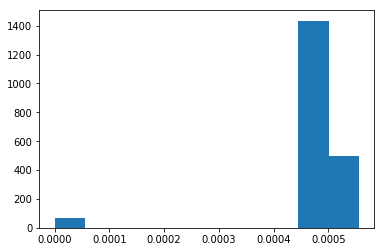

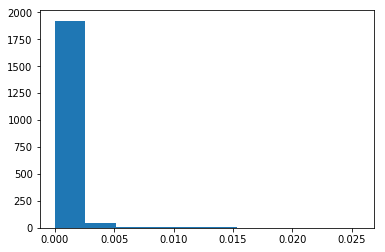

0.9674899644375732


In [204]:
import matplotlib.pyplot as plt
%matplotlib inline
weight = np.load("weight.npy")
fre = np.load("frequency.npy")
plt.hist(weight)
plt.show()
plt.hist(fre)
plt.show()

print np.sum(weight)

In [132]:
quadratic_solver(3,aaa.T,-ccc,0.00)

(array([-1., -2., -7.]), -3492.2450000000003, array([-1., -2., -7.]), array([1, 0], dtype=int32), array([0., 0., 0., 0.]), array([], dtype=int32))


array([-1., -2., -7.])

In [130]:
def quadratic_solver(n, M, bbb , regularizer):
    qp_G = np.matmul(M, M.T)
    qp_G += regularizer * np.eye(n)

    qp_a = np.matmul(M, bbb)###np.zeros(n, dtype = np.float64)
    
    qp_C = np.zeros((n,n+1), dtype = np.float64)
    for i in range(n):
        qp_C[i,0] = 0.0
        qp_C[i,i+1] = 0.0
    qp_b = np.zeros(n+1, dtype = np.float64)
    qp_b[0] = 0.0
    meq = 0.0

    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    print res
    w = res[0]
    return w

In [193]:
weight = np.load("weight.npy")

(array([2.180e+02, 1.066e+03, 4.340e+02, 1.590e+02, 7.500e+01, 2.700e+01,
        1.100e+01, 7.000e+00, 2.000e+00, 1.000e+00]),
 array([0.        , 0.09314198, 0.18628396, 0.27942594, 0.37256792,
        0.4657099 , 0.55885188, 0.65199386, 0.74513584, 0.83827782,
        0.9314198 ]),
 <a list of 10 Patch objects>)

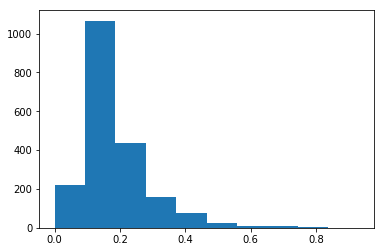

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(weight)